# Variational AutoEncoders for Image Generation.
Finally something new!

# AutoEncoder for image reconstruction

To show simple results I'll use MNIST for this one.

In [2]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
train_dataset = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

train_dataset, val_dataset, test_dataset

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 363kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.39MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.67MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
m_samples = len(train_dataset)
train_ratio = 0.8
indices = np.arange(m_samples)
np.random.shuffle(indices)

train_indices = indices[:int(train_ratio * m_samples)]
val_indices = indices[int(train_ratio * m_samples):]

train_sampler = RandomSampler(train_indices)
val_sampler = RandomSampler(val_indices)

train_dataloader = DataLoader(
    train_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count(), sampler=train_sampler
)
val_dataloader = DataLoader(
    val_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count(), sampler=val_sampler
)
test_dataloader = DataLoader(
    test_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count()
)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(375, 94, 79)

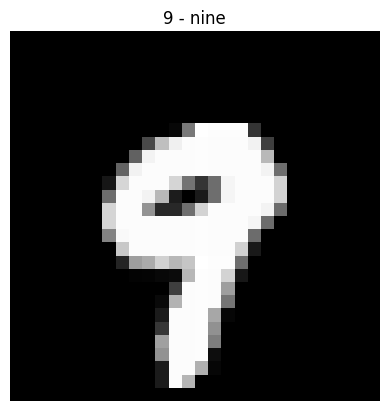

In [6]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0]
    label = label_batch[0]

    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0), cmap="gray");
    break

## Let's build autoencoder now!

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2),  # 13x13x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2),  # 6x6x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=2),  # 4x4x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 2, kernel_size=3, stride=2, padding=1),  # 2x2x2
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        # return torch.reshape(self.encoder(x), (128, 8, 1, 1))
        x = self.encoder(x)
        batch_size = x.shape[0]
        return x.view(batch_size, 8, 1, 1)

In [8]:
encoda = Encoder(1)
summary(encoda, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [128, 8, 1, 1]            --
├─Sequential: 1-1                        [128, 8]                  --
│    └─Conv2d: 2-1                       [128, 32, 13, 13]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 13, 13]         64
│    └─ReLU: 2-3                         [128, 32, 13, 13]         --
│    └─Conv2d: 2-4                       [128, 16, 6, 6]           4,624
│    └─BatchNorm2d: 2-5                  [128, 16, 6, 6]           32
│    └─ReLU: 2-6                         [128, 16, 6, 6]           --
│    └─Conv2d: 2-7                       [128, 8, 4, 4]            1,160
│    └─BatchNorm2d: 2-8                  [128, 8, 4, 4]            16
│    └─ReLU: 2-9                         [128, 8, 4, 4]            --
│    └─Conv2d: 2-10                      [128, 2, 2, 2]            146
│    └─BatchNorm2d: 2-11                 [128, 2, 2, 2]            4
│    └─R

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input is (128x8x1x1)
        # Output Size=(Input Size−1)×Stride−2×Padding+Kernel Size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, kernel_size=4, stride=1, padding=0),  # (128x64x4x4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (128x32x8x8)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # (128x16x16x16),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2),  # (128x1x28x28)
        )

    def forward(self, x):
        return self.decoder(x)

In [10]:
decoda = Decoder()
summary(decoda, input_size=(128, 8, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 1, 28, 28]          --
│    └─ConvTranspose2d: 2-1              [128, 64, 4, 4]           8,256
│    └─BatchNorm2d: 2-2                  [128, 64, 4, 4]           128
│    └─ReLU: 2-3                         [128, 64, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [128, 32, 8, 8]           32,800
│    └─BatchNorm2d: 2-5                  [128, 32, 8, 8]           64
│    └─ReLU: 2-6                         [128, 32, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [128, 16, 16, 16]         8,208
│    └─BatchNorm2d: 2-8                  [128, 16, 16, 16]         32
│    └─ReLU: 2-9                         [128, 16, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [128, 1, 28, 28]          65
Total params: 49,553
Trainable params: 49,553
Non-trainable params: 0
Tota

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_space = self.encoder(x)
        generation = self.decoder(latent_space)
        return generation

In [12]:
autoencoder = AutoEncoder(encoda, decoda)
summary(autoencoder, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [128, 1, 28, 28]          --
├─Encoder: 1-1                           [128, 8, 1, 1]            --
│    └─Sequential: 2-1                   [128, 8]                  --
│    │    └─Conv2d: 3-1                  [128, 32, 13, 13]         320
│    │    └─BatchNorm2d: 3-2             [128, 32, 13, 13]         64
│    │    └─ReLU: 3-3                    [128, 32, 13, 13]         --
│    │    └─Conv2d: 3-4                  [128, 16, 6, 6]           4,624
│    │    └─BatchNorm2d: 3-5             [128, 16, 6, 6]           32
│    │    └─ReLU: 3-6                    [128, 16, 6, 6]           --
│    │    └─Conv2d: 3-7                  [128, 8, 4, 4]            1,160
│    │    └─BatchNorm2d: 3-8             [128, 8, 4, 4]            16
│    │    └─ReLU: 3-9                    [128, 8, 4, 4]            --
│    │    └─Conv2d: 3-10                 [128, 2, 2, 2]            146
│    │ 

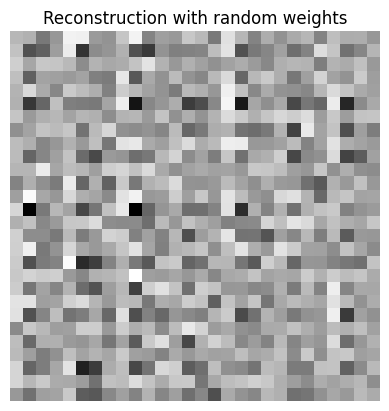

In [13]:
# RANDOM SHIT FOR NOW!
for image_batch, _ in train_dataloader:
    dream = autoencoder(image_batch)
    dream_sample = dream[0]
    plt.title("Reconstruction with random weights")
    plt.axis("off")
    plt.imshow(dream_sample.permute(1, 2, 0).detach().numpy(), cmap="gray");
    break

## Training AutoEncoder

In [14]:
encoder = Encoder(input_channels=1)
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder)

loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(params=autoencoder.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

epoch: 1. Train loss: 0.06511742621660233
epoch: 1. Val loss: 0.044144630432128906
epoch: 2. Train loss: 0.03993662819266319
epoch: 2. Val loss: 0.03710431605577469
epoch: 3. Train loss: 0.03353121131658554
epoch: 3. Val loss: 0.030777746811509132
epoch: 4. Train loss: 0.030553551390767097
epoch: 4. Val loss: 0.029303358867764473


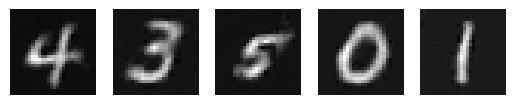

epoch: 5. Train loss: 0.028583234176039696
epoch: 5. Val loss: 0.02624243125319481
epoch: 6. Train loss: 0.024649541825056076
epoch: 6. Val loss: 0.023306140676140785
epoch: 7. Train loss: 0.023914547637104988
epoch: 7. Val loss: 0.022610940039157867
epoch: 8. Train loss: 0.023428533226251602
epoch: 8. Val loss: 0.02218405157327652


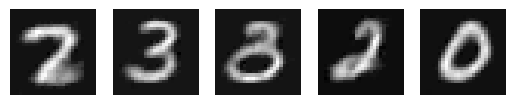

epoch: 9. Train loss: 0.023060040548443794
epoch: 9. Val loss: 0.02193465642631054
epoch: 10. Train loss: 0.022762972861528397
epoch: 10. Val loss: 0.02155604213476181
epoch: 11. Train loss: 0.021983962506055832
epoch: 11. Val loss: 0.020915893837809563
epoch: 12. Train loss: 0.021790551021695137
epoch: 12. Val loss: 0.02082526870071888


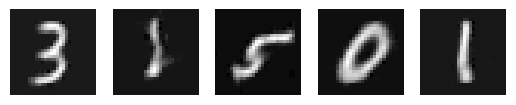

epoch: 13. Train loss: 0.021748103201389313
epoch: 13. Val loss: 0.020703045651316643
epoch: 14. Train loss: 0.021624715998768806
epoch: 14. Val loss: 0.02058952860534191
epoch: 15. Train loss: 0.021547965705394745
epoch: 15. Val loss: 0.020436877384781837
epoch: 16. Train loss: 0.02130502089858055
epoch: 16. Val loss: 0.020324891433119774


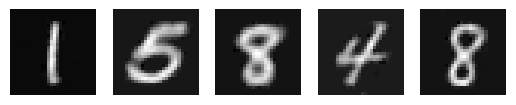

epoch: 17. Train loss: 0.021281104534864426
epoch: 17. Val loss: 0.02029016613960266
epoch: 18. Train loss: 0.02127196080982685
epoch: 18. Val loss: 0.02024337276816368
epoch: 19. Train loss: 0.021233469247817993
epoch: 19. Val loss: 0.020238298922777176
epoch: 20. Train loss: 0.021221444010734558
epoch: 20. Val loss: 0.02019532583653927


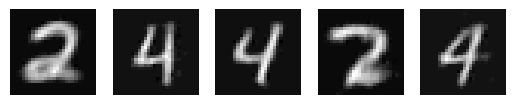

In [15]:
epochs = 20

for epoch in range(epochs):
    # Train step
    autoencoder.train()
    train_loss = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        
        dream = autoencoder(image_batch)
        loss = loss_fn(dream, image_batch)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch + 1}. Train loss: {train_loss / len(train_dataloader)}")
    lr_scheduler.step()

    # Val step
    autoencoder.eval()
    with torch.inference_mode():
        val_loss = 0
        for image_batch, _ in val_dataloader:
            image_batch = image_batch.to(device)
    
            dream = autoencoder(image_batch)
            loss = loss_fn(dream, image_batch)
            val_loss += loss
    
        print(f"epoch: {epoch + 1}. Val loss: {val_loss / len(val_dataloader)}")

    if (epoch + 1) % 4 == 0:
        fig=plt.figure()
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.axis("off")
            plt.imshow(dream[i].permute(1, 2, 0).detach().numpy(), cmap="gray")
        plt.show();

In [16]:
latent = torch.rand((1, 8, 1, 1))

In [17]:
with torch.inference_mode():
    dream = autoencoder.decoder(latent)

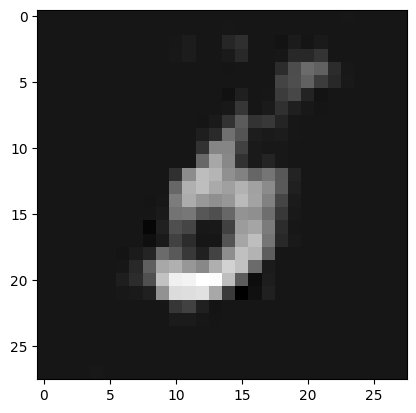

In [18]:
plt.imshow(dream.squeeze(0).permute(1, 2, 0), cmap="gray");

## Variational AutoEncoders!
It is a probabilistic improvement of autoencoders

In [19]:
class VEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2),  # 13x13x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2),  # 6x6x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=2),  # 4x4x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4*4*8, 400),
            nn.ReLU()
        )
        self.mean = nn.Linear(400, latent_dim)  # Mean for latent distribution
        self.logvar = nn.Linear(400, latent_dim)  # Log variance for latent distribution

    def forward(self, x):
        hidden = self.encoder(x)
        mu = self.mean(hidden)
        logvar = self.logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Makes sampling diffirentiable
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [20]:
class VDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 4*4*8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 4, 4)),  # (B, 8, 4, 4)
            nn.ConvTranspose2d(8, 64, kernel_size=4, stride=1, padding=0),  # (B, 64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 28, 28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # (B, 1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder_input(x)
        return self.decoder(x)

In [21]:
import torch.nn.functional as F

In [22]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, input_channels=1, latent_dim=8):
        super().__init__()
        self.encoder = encoder(input_channels, latent_dim)
        self.decoder = decoder(latent_dim)

    def forward(self, x):
        mu, var = self.encoder(x)
        z = self.encoder.reparameterize(mu, var)
        # z = z.view(z.shape[0], z.shape[1], 1, 1)
    
        return self.decoder(z), mu, var


def vae_loss(reconstruction, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    # KL divergence measures how far the learned distribution is from the standard normal).
    # It's sort of regularization term to keep our distribution close to the standard normal
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL


In [81]:
vae = VAE(VEncoder, VDecoder, input_channels=1, latent_dim=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [82]:
vae.to(device)

epochs = 20

epoch: 1. Train loss: 19225.720703125
epoch: 1. Val loss: 15238.8271484375
epoch: 2. Train loss: 15003.861328125
epoch: 2. Val loss: 14382.1796875
epoch: 3. Train loss: 14417.509765625
epoch: 3. Val loss: 14125.6201171875
epoch: 4. Train loss: 14091.4267578125
epoch: 4. Val loss: 13743.3095703125


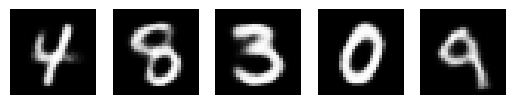

epoch: 5. Train loss: 13890.8505859375
epoch: 5. Val loss: 13555.3603515625
epoch: 6. Train loss: 13710.740234375
epoch: 6. Val loss: 13443.37109375
epoch: 7. Train loss: 13599.8212890625
epoch: 7. Val loss: 13411.51171875
epoch: 8. Train loss: 13508.974609375
epoch: 8. Val loss: 13248.041015625


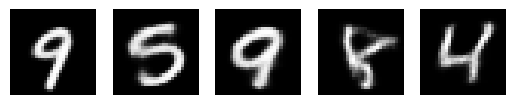

epoch: 9. Train loss: 13431.1689453125
epoch: 9. Val loss: 13246.3935546875
epoch: 10. Train loss: 13368.5576171875
epoch: 10. Val loss: 13161.8203125
epoch: 11. Train loss: 13326.7744140625
epoch: 11. Val loss: 13183.9150390625
epoch: 12. Train loss: 13249.703125
epoch: 12. Val loss: 12990.298828125


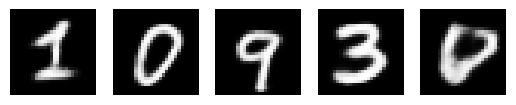

epoch: 13. Train loss: 13213.0595703125
epoch: 13. Val loss: 13029.0302734375
epoch: 14. Train loss: 13180.572265625
epoch: 14. Val loss: 12980.1650390625
epoch: 15. Train loss: 13147.1142578125
epoch: 15. Val loss: 12904.1552734375
epoch: 16. Train loss: 13097.5439453125
epoch: 16. Val loss: 12893.74609375


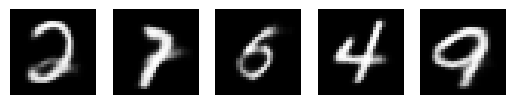

epoch: 17. Train loss: 13076.9404296875
epoch: 17. Val loss: 12872.1357421875
epoch: 18. Train loss: 13042.1630859375
epoch: 18. Val loss: 12829.3203125
epoch: 19. Train loss: 13020.1611328125
epoch: 19. Val loss: 12791.6318359375
epoch: 20. Train loss: 13000.2841796875
epoch: 20. Val loss: 12804.4736328125


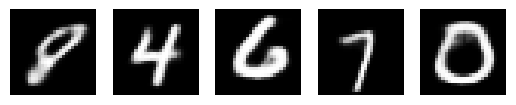

In [83]:
for epoch in range(epochs):
    # Train step
    vae.train()
    train_loss = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        
        dream, mu, logvar = vae(image_batch)
        loss = vae_loss(dream, image_batch, mu, logvar)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch + 1}. Train loss: {train_loss / len(train_dataloader)}")
    # lr_scheduler.step()

    # Val step
    vae.eval()
    with torch.inference_mode():
        val_loss = 0
        for image_batch, _ in val_dataloader:
            image_batch = image_batch.to(device)
    
            dream, _, _ = vae(image_batch)
            loss = vae_loss(dream, image_batch, mu, logvar)
            val_loss += loss
    
        print(f"epoch: {epoch + 1}. Val loss: {val_loss / len(val_dataloader)}")

    if (epoch + 1) % 4 == 0:
        fig=plt.figure()
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.axis("off")
            plt.imshow(dream[i].permute(1, 2, 0).detach().numpy(), cmap="gray")
        plt.show();

In [94]:
logvar = torch.rand((1, 10))
mu = torch.rand((1, 10))
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z_new = mu + eps * std

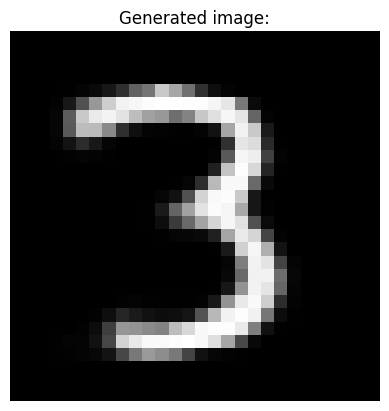

In [95]:
plt.title("Generated image:")
plt.axis("off")
plt.imshow(vae.decoder(z_new).squeeze(0).permute(1, 2, 0).detach().numpy(), cmap="gray");

<img src="https://media.tenor.com/e1NhKU9MMkwAAAAi/ez.gif" width=20%>